In [1]:
%%time

#titanicコンペ
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import warnings
# filter warnings
warnings.filterwarnings('ignore')

#データファイルの読み込み
train = pd.read_csv("../../input/titanic/train.csv")
test = pd.read_csv("../../input/titanic/test.csv")
gender_submission = pd.read_csv("../../input/titanic/gender_submission.csv")

CPU times: user 153 ms, sys: 29.7 ms, total: 183 ms
Wall time: 262 ms


In [2]:
%%time
#特徴量エンジニアリング-start
#kaggleではtrainとtestを結合
data = pd.concat([train,test])
print(data.shape)
#data.head()

#Sex:性別は文字列なので数値に変換する:inplaceオプションで元データも書き換え
data['Sex'].replace(['male','female'],[0, 1], inplace=True)

#Embarkedには欠損値があるので大多数を占める「S」でうめる
data['Embarked'].fillna(('S'), inplace=True)
##Embarkedは文字列なので数値に変換
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#運賃も関係あるかも
#一つ欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Sex'].value_counts()
data['Embarked'].value_counts()
#data['Fare'].value_counts()



(1309, 12)
CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 13.2 ms


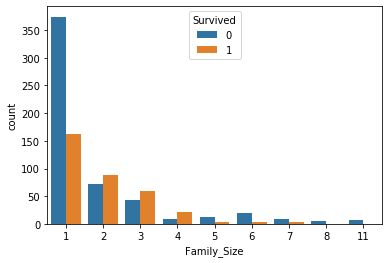

In [3]:
#家族の人数が多いと生存率がさがるのでは？という仮設を立てる
#「家族の人数」を示す特徴量を作る
#データの中に「Parch：兄弟姉妹/配偶者の数」、「SibSp：親子の数」があるので
#これを足して特徴量を生成
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
train['Family_Size'] = data['Family_Size'][:len(train)]
test['Family_Size'] = data['Family_Size'][len(train):]

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Family_Size', data = train, hue = 'Survived')

#一人だけの乗客と5人以上の家族連れは生存率が低い
#「一人だけ」という特徴量も作る

data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

#train.head()

In [4]:
%%time
#運賃も欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

#Age：年齢も加味してみる
age_avg = data['Age'].mean()
age_std = data['Age'].std()
#平均年齢に標準へ差の幅で欠損値を埋める
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
#train.head()
#data.head()

#とりあえずここまでで特徴量を考慮しなかった列は削除
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis = 1, inplace = True)

CPU times: user 2.96 ms, sys: 462 µs, total: 3.42 ms
Wall time: 2.53 ms


In [26]:
#特徴量エンジニアリング後のデータについてtrainとtestにわける
train = data[:len(train)]
test = data[len(train):]

print(train.shape)
train.head()

(891, 8)


,Age,Embarked,Fare,Pclass,Sex,Survived,Family_Size,IsAlone
0,22.0,0,7.2500,3,0,0.0,2,0
1,38.0,1,71.2833,1,1,1.0,2,0
2,26.0,0,7.9250,3,1,1.0,1,1
3,35.0,0,53.1000,1,1,1.0,2,0
4,35.0,0,8.0500,3,0,0.0,1,1


In [31]:
#x_train：学習データ、正解ラベル(Survived)の列は削除
#y_train：学習データ、正解ラベル(Survived)のみとする
#x_test：検証データ、正解ラベル(Survived)の列は削除

y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)
y_test = test['Survived']

#確認
print("x_train:" + str(X_train.shape))
print("y_train:" + str(y_train.shape))
print("x_test:" + str(X_test.shape))
print("y_test:" + str(y_test.shape))
X_train.head()

x_train:(891, 7)
y_train:(891,)
x_test:(418, 7)
y_test:(418,)


,Age,Embarked,Fare,Pclass,Sex,Family_Size,IsAlone
0,22.0,0,7.2500,3,0,2,0
1,38.0,1,71.2833,1,1,2,0
2,26.0,0,7.9250,3,1,1,1
3,35.0,0,53.1000,1,1,2,0
4,35.0,0,8.0500,3,0,1,1


In [17]:
# lightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:

#データセットを訓練データとテストデータに分ける
#[train_test_split]は訓練データ:75%、テストデータ:25%に分割になる
#x_train,x_test,y_train,y_test = train_test_split(iris_data['data'],iris_data['target'],random_state=0)


# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

# LightGBMの分類器をインスタンス化
gbm = lgb.LGBMClassifier(objective='binary')

# trainとvalidを指定し学習
gbm.fit(train_x, train_y, eval_set = [(valid_x, valid_y)],
        early_stopping_rounds=20,  # 20回連続でlossが下がらなかったら終了
        verbose=10  # 10round毎に、lossを表示
) ;

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.453937
[20]	valid_0's binary_logloss: 0.407842
[30]	valid_0's binary_logloss: 0.392726
[40]	valid_0's binary_logloss: 0.398816
[50]	valid_0's binary_logloss: 0.402984
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.392726


In [14]:
# valid_xについて推論
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)  # oofはout of fold
print('score', round(accuracy_score(valid_y, oof)*100,2), '%')  # 正解率の表示

# out of foldは学習に使っているデータ以外の予測

score 82.71 %


In [37]:
# testの予測
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)  # testの予測
y_true = gender_submission['Survived']

print('score', round(accuracy_score(y_true, y_pred)*100,2), '%')

score 90.19 %


In [38]:
#パラメータ調整
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [39]:
from sklearn.model_selection import GridSearchCV

gbm = lgb.LGBMClassifier(objective='binary')

# 試行するパラメータを羅列する
params = {
    'max_depth': [2, 3, 4, 5],
    'reg_alpha': [0, 1, 10, 100],
    'reg_lambda': [0, 1, 10, 100],
}

grid_search = GridSearchCV(
                           gbm,  # 分類器を渡す
                           param_grid=params,  # 試行してほしいパラメータを渡す
                           cv=3,  # 3分割交差検証でスコアを確認
                          )

grid_search.fit(X_train, y_train)  # データを渡す

print(grid_search.best_score_)  # ベストスコアを表示
print(grid_search.best_params_)  # ベストスコアのパラメータを表示

0.8395061728395061
{'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 0}


In [51]:
# 3分割交差検証を指定し、インスタンス化
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)  # 3分割交差検証のためにインスタンス化

# スコアとモデルを格納するリスト
score_list = []
score_list2 = []
test_pred = np.zeros((len(test), 3))

X_train.head()
#y_train



,Age,Embarked,Fare,Pclass,Sex,Family_Size,IsAlone
0,22.0,0,7.2500,3,0,2,0
1,38.0,1,71.2833,1,1,2,0
2,26.0,0,7.9250,3,1,1,1
3,35.0,0,53.1000,1,1,2,0
4,35.0,0,8.0500,3,0,1,1


In [52]:
#y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)  # testの予測
#y_true = gender_submission['Survived']
#print('score', round(accuracy_score(y_true, y_pred)*100,2), '%')

for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train[train_index]
    valid_y = y_train[valid_index]
    
    print(f'fold{fold_ + 1} start')

    #GridSerchCVの結果はここに入れる
    gbm = lgb.LGBMClassifier(objective='binary', max_depth=4, reg_alpha=1,
                             reg_lambda=0)
    gbm.fit(train_x, train_y,
            eval_set = [(valid_x, valid_y)],
            early_stopping_rounds=20,
            verbose= -1)
    
    oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
    score_list.append(round(accuracy_score(valid_y, oof)*100,2))
    #test_pred[:, fold_] = gbm.predict(test, num_iteration=gbm.best_iteration_)
    test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    score_list2.append(round(accuracy_score(y_true, y_pred)*100,2))
    #print(f'fold{fold_ + 1} end\n' )
print(score_list, '平均score', np.mean(score_list))
print(score_list2, '平均score2', np.mean(score_list2))

#pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)
#sample_submission['Survived'] = pred
#sample_submission.to_csv('glid_search.csv', index=False)

fold1 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.457991
fold2 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.405636
fold3 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.384793
[80.81, 83.84, 82.83] 平均score 82.49333333333334
[90.19, 90.19, 90.19] 平均score2 90.19
